# Face Segmentation

## Summary
This notebook demonstrates the processing of devloping a classifier for segmenting parts of a human face. The notebook is split into three sections.

## Setup / Imports
This section imports the required packages, there is some complexity as I wanted this notebook to run on both a local jupyter notebook and google colab.

In [2]:
# Standard imports
import sys
import importlib
import pandas as pd
import numpy as np
import re
import joblib
import pickle

# Imports for plotting
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

# Are we running on local or colab?
if 'edwardrees' in sys.exec_prefix:
    device_loc = 'local'
else:
    device_loc = 'colab'

# Print where running
print('Running on', device_loc)

# Mount drive if on colab
if device_loc == 'colab':
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)

# Add local drive to path if running on colab
if device_loc == 'local':
    dir_ = '..'
elif device_loc == 'colab':
    dir_ = 'drive/My Drive/GA/Capstone'
    sys.path.append(dir_)
sys.path.append(f'{dir_}/src')


# Images and loading
from skimage import io, util
import os
from matplotlib import cm
from matplotlib.colors import ListedColormap

# Progress bars, tqdm.notebook doesn't work on colab
if device_loc == 'colab':
    !pip install --force https://github.com/chengs/tqdm/archive/colab.zip
    from tqdm import tqdm_notebook as tqdm
elif device_loc == 'local':
    from tqdm.notebook import tqdm

# Import my functions
import image_processing as ip
import label_processing as lbp
import feature_processing as ftp

# Models
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import skimage.measure

Running on local


## Constants and Setup

In [3]:
# Setup a better colour map for plotting segmented faces
newcolors = cm.get_cmap('rainbow', 256)(np.linspace(0, 1, 10))
pink = np.array([0, 0, 0, 1])
newcolors[0, :] = pink
#newcmp = ListedColormap(newcolors)
newcmp=plt.cm.get_cmap('Set1', 8)

In [4]:
# The following dictionary indiciates in r-g-b what the colors are in the original labels
label_dict = {
    'mouth': ['0-255-0', 1],
    'skin': ['255-255-0', 6],
    'hair': ['127-0-0', 5],
    'padding': ['0-0-0', 0],
    'nose': ['0-255-255', 2],
    'eyes': ['0-0-255', 3],
    'background': ['255-0-0', 7]
}

# List to convert numerical label to class label
output_labels = [
    'nc',
    'mouth',
    'nose',
    'left eye',
    'right eye',
]

# What size we should make the images
IMG_SHAPE = (600, 600)

# Dataset locations
seg_v2_RGB_dir = dir_ + '/data/raw/FASSEG_v2/RGB'
seg_v2_labels_dir = dir_ + '/data/raw/FASSEG_v2/Labels'
seg_v3_RGB_dir = dir_ + '/data/raw/FASSEG_v3/RGB'
seg_v3_labels_dir = dir_ + '/data/raw/FASSEG_v3/Labels'

#real_dir = dir_+'/rawdata/real_and_fake_face/training_real'
#fake_dir = dir_+'/rawdata/real_and_fake_face/training_fake'

In [5]:
def reload_modules():
    '''
    Reload my custom modules in case something has changed
    '''
    importlib.reload(ip)
    importlib.reload(lbp)
    importlib.reload(ftp)

## FASSEG functions
I wrote some utility functions here to streamline model evaluation and data exploration

In [6]:
def score_seg_model(model, X_test, y_test):
    model.verbose = 0
    print('Accuracy Score', model.score(X_test, y_test))
    y_test_predict = model.predict(X_test)

    print(
        classification_report(y_test,
                              y_test_predict,
                              target_names=output_labels))

In [7]:
def view_prediction(model, img, feature_params, **kwargs):
    '''
    This function dispalys the image along with the associated model prediction, feature_params of
    the model used must be specified. ground_truth is an optional argument to pass the original
    label. overlap=True will dispaly the predicted labels overlaid on the original image.
    '''

    y_real_predict = model.predict(ftp.create_features(img, feature_params))

    n_imgs = 2

    if 'ground_truth' in kwargs:
        n_imgs += 1
        gt = n_imgs - 1

    if 'overlap' in kwargs:
        n_imgs += 1
        ovl = n_imgs - 1

    Y_predict = y_real_predict.reshape(img.shape[:2])

    fig, ax = plt.subplots(ncols=n_imgs, figsize=(5 * n_imgs, 6))
    ax[0].axis('off')
    ax[1].axis('off')
    ax[0].imshow(img)
    ax[1].imshow(Y_predict, cmap=newcmp)
    ax[0].set_title('Image')
    ax[1].set_title('Segmented Image')

    if 'ground_truth' in kwargs:
        ax[gt].axis('off')
        ax[gt].imshow(kwargs['ground_truth'], cmap=newcmp)
        ax[gt].set_title('Ground Truth')

    if 'overlap' in kwargs:
        ax[ovl].axis('off')
        ax[ovl].imshow(img)
        ax[ovl].imshow(Y_predict, alpha=kwargs['overlap'], cmap=newcmp)
        ax[ovl].set_title('Prediction overlap')

In [8]:
def view_data(X, Y, index=None):
    '''
    This is a utility function to inspect both the image and associated labels.
    '''
    if index is not None:
        img = X[index]
        label = Y[index]
    else:
        img = X
        label = Y

    fig, ax = plt.subplots(ncols=3, figsize=(15, 6))
    ax[0].axis('off')
    ax[1].axis('off')
    ax[0].imshow(img)
    ax[1].imshow(label, cmap=newcmp)
    ax[2].imshow(img)
    ax[2].imshow(label, alpha=0.25, cmap=newcmp)
    ax[0].set_title('Image')
    ax[1].set_title('Segmented Image')
    ax[2].set_title('Superimpsed')

## EDA / Cleaning

In [9]:
# Load some of the iamges and inspect, this utilies the function I wrote load_images
# loads the images and corresponding labels 

img_sample, label_sample = ip.load_images(seg_v2_RGB_dir, seg_v2_labels_dir)
show = 2
img_sample = ip.convert_images_to_array(img_sample[:show], img_shape=(600,600))
label_sample = ip.convert_images_to_array(label_sample[:show], img_shape=(600,600))

Converting images to np array: 100%|██████████| 2/2 [00:00<00:00, 17.57it/s]


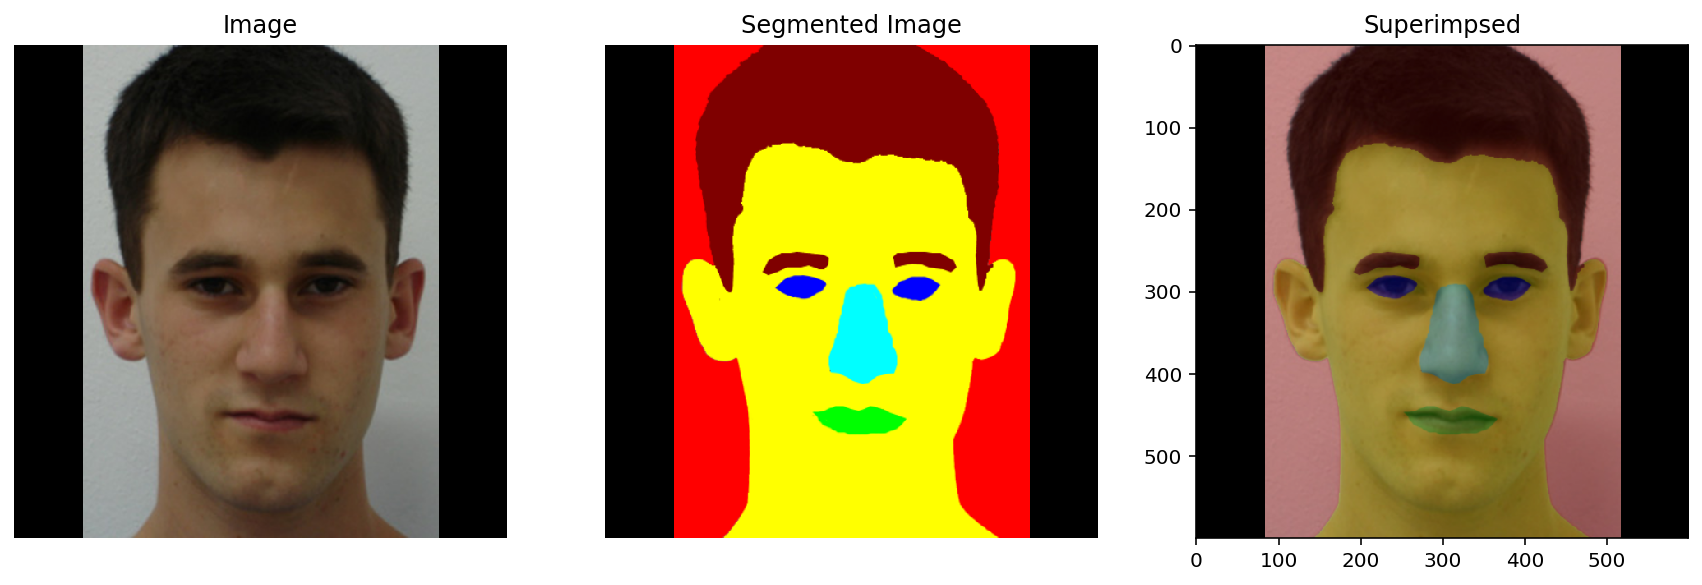

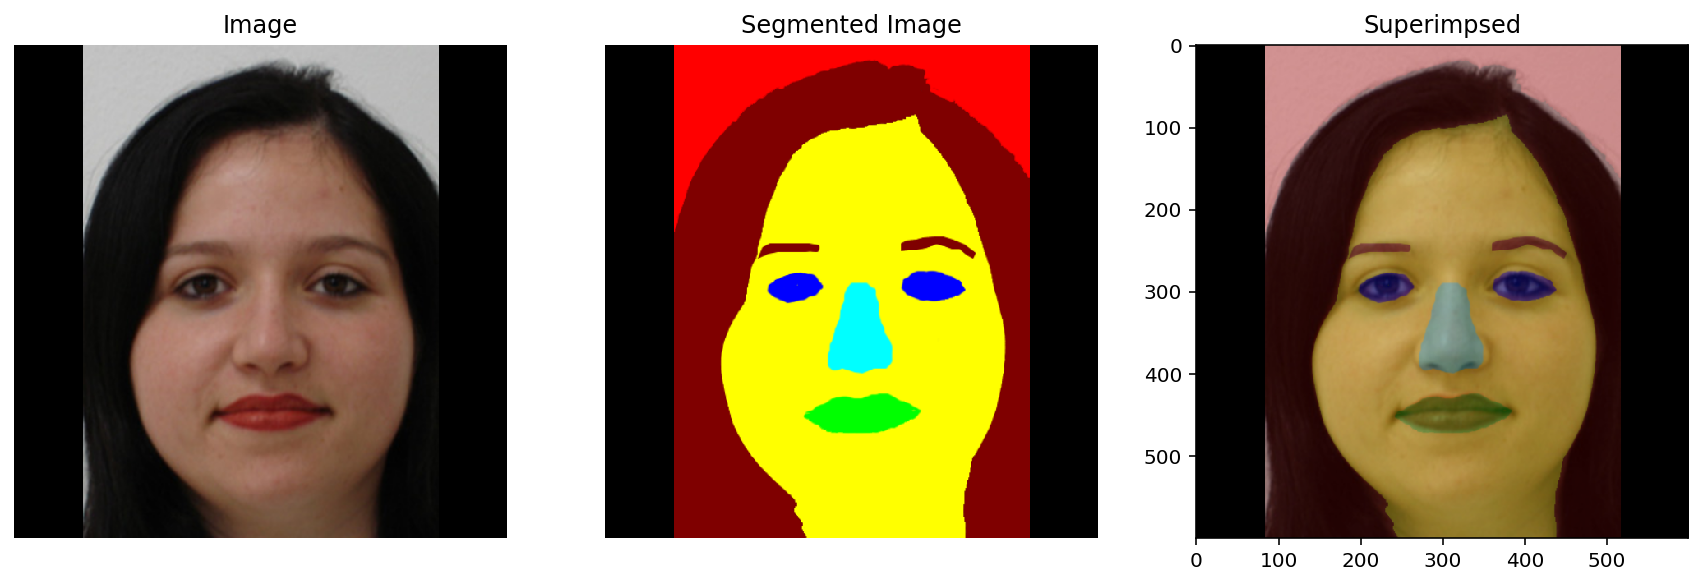

In [10]:
for i,_ in enumerate(img_sample):
    view_data(img_sample, label_sample, i)

Whilst the iamges all have the same height they have different widths, so I wrote a function to zero pad the images and resize them so that they are all the same size.

Additionally looking at the labels it is clear that there are more unique colors then there are classes, this is because the images are in jpeg format and hence have lost some of their precision. These labels need to be fixed before they can be used to train the model.

In [11]:
np.unique(label_sample[0], return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

To fix this I wrote some functions that translate the rgb color into pixelwise categorical labels

In [12]:
# Really two steps to this, first is to group the colours into 6 (7 if there is padding) 
# distinct categories, this was done
# using the KMeans clustering algorithm

reload_modules()

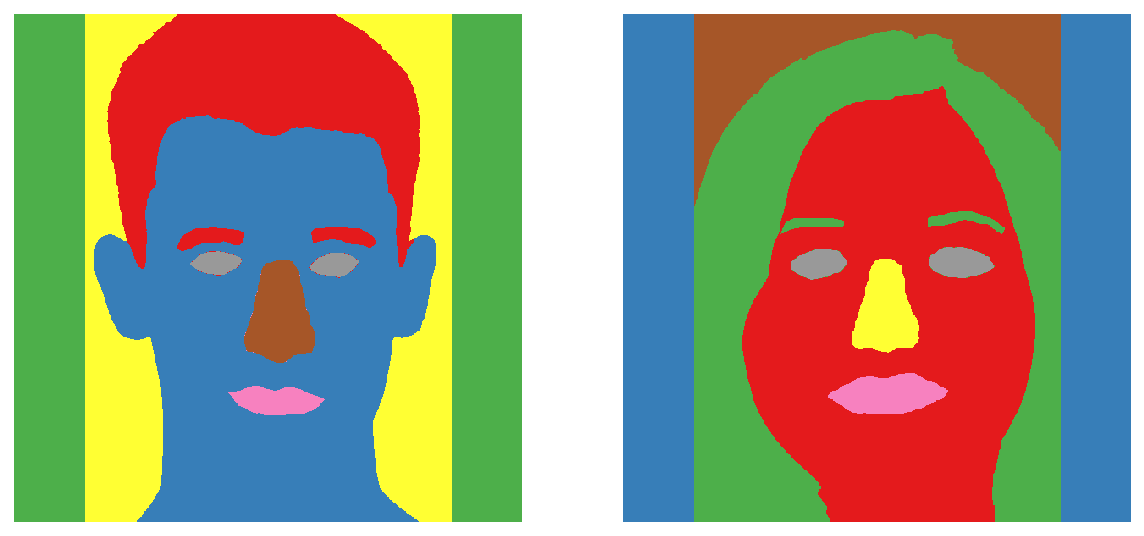

In [13]:
clustered_label_1 = lbp.run_kmeans(label_sample[0], n_clusters=7)
clustered_label_2 = lbp.run_kmeans(label_sample[1], n_clusters=7)

fig, ax = plt.subplots(ncols=2, figsize=(10, 6))
ax[0].axis('off')
ax[1].axis('off')
ax[0].imshow(clustered_label_1, cmap = newcmp)
ax[1].imshow(clustered_label_2, cmap = newcmp)

In [14]:
np.unique(clustered_label_1, return_counts=True)

(array([1, 2, 3, 4, 5, 6, 7], dtype=int32),
 array([ 55665, 123879, 100200,  67960,   7113,   2806,   2377]))

> The labels have now been reduced but the labels are not consitent across the different images, for
this reason it was necessary to write another function that maps the labels

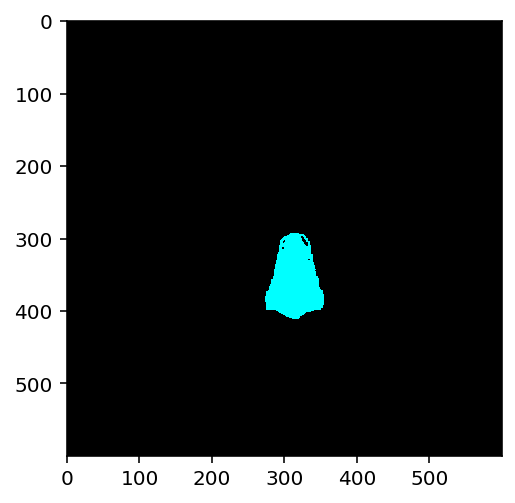

In [15]:
masked_label = lbp.mask_image(label_sample[0], 'nose', label_dict, method='color_label', return_type = 'original')
plt.imshow(masked_label)

This then allows a comparison with the output of the KMeans clustering algorithm so that the labels then match up

In [16]:
seg1 = lbp.segment_labeled_image(
    label_sample[0],
    n_clusters=7,
    label_dict=label_dict,
    desired_labels=['skin', 'nose', 'mouth', 'eyes', 'hair'])
seg2 = lbp.segment_labeled_image(
    label_sample[1],
    n_clusters=7,
    label_dict=label_dict,
    desired_labels=['skin', 'nose', 'mouth', 'eyes', 'hair'])

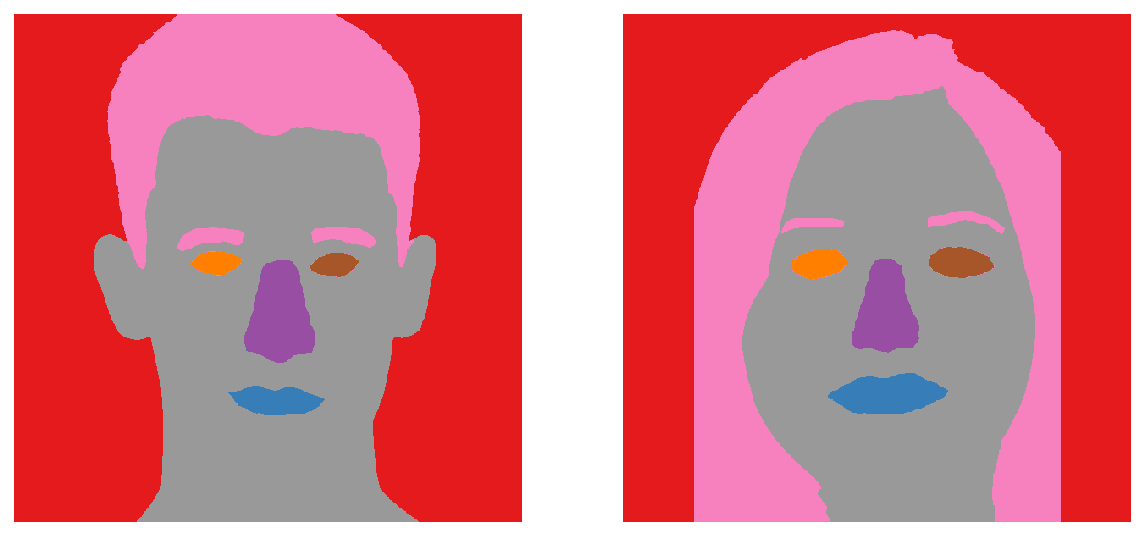

In [17]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 6))
ax[0].axis('off')
ax[1].axis('off')
ax[0].imshow(seg1, cmap=newcmp)
ax[1].imshow(seg2, cmap=newcmp)

## FASSEG Loading / Pre-processing


In [22]:
# Labels have some noise so segment them to obtain clean categories,
force_recalculate = False
save_path = '../data/processed/segmentation/imgs_array.npz'

if not os.path.exists(save_path) or force_recalculate:

    # Check that the segmentation folder exists
    if not os.path.exists('../data/processed/segmentation'):
        os.makedirs('../data/processed/segmentation')

    # Load images from FASSEG V2 database and save the result as two lists
    seg_v2_RGB, seg_v2_labels = ip.load_images(seg_v2_RGB_dir,
                                               seg_v2_labels_dir)

    # Load images from FASSEG V3 database and save the result as two lists
    seg_v3_RGB, seg_v3_labels = ip.load_images(seg_v3_RGB_dir,
                                               seg_v3_labels_dir)

    # Combine V2 and V3 into a combined list
    seg_v2_v3_RGB = seg_v2_RGB + seg_v3_RGB
    seg_v2_v3_labels = seg_v2_labels + seg_v3_labels

    # Convert list of images to numpy array
    X = ip.convert_images_to_array(seg_v2_v3_RGB, IMG_SHAPE, method='zero_pad')
    Y = ip.convert_images_to_array(seg_v2_v3_labels,
                                   IMG_SHAPE,
                                   method='zero_pad')

    # Segment the Y labels
    Y = lbp.segment_labeled_images(Y, n_clusters=7, label_dict=label_dict)

    # Save the results as this takes a while to run
    np.savez_compressed(save_path, imgs=X, labels=Y)
    print('Saved semgentation labels')

else:
    # Else Load the segmented labels if
    loaded = np.load(save_path)
    X = loaded['imgs']
    Y = loaded['labels']
    print('Loaded semgentation labels')

Loaded semgentation labels


In [23]:
# Downsample the images and convert to float, must divide the original IMG_SHAPE
ds_shape = (150, 150)
ds_kernel = (IMG_SHAPE[0] // ds_shape[0], IMG_SHAPE[1] // ds_shape[1])
X_ds = ip.resize_images(X,
                        ds_shape,
                        convert_to_ubyte=False,
                        preserve_range=False)

# Downsample labels by max pooling, use (4,4) to ma
Y_ds = lbp.max_pool_labels(Y, kernel=(4, 4), single_img=False)

Resizing images: 100%|██████████| 80/80 [00:02<00:00, 30.44it/s]


In [24]:
# Train test split
X_train, X_test, Y_train, Y_test = train_test_split(X_ds,
                                                    Y_ds,
                                                    shuffle=True,
                                                    random_state=0,
                                                    train_size=0.7)

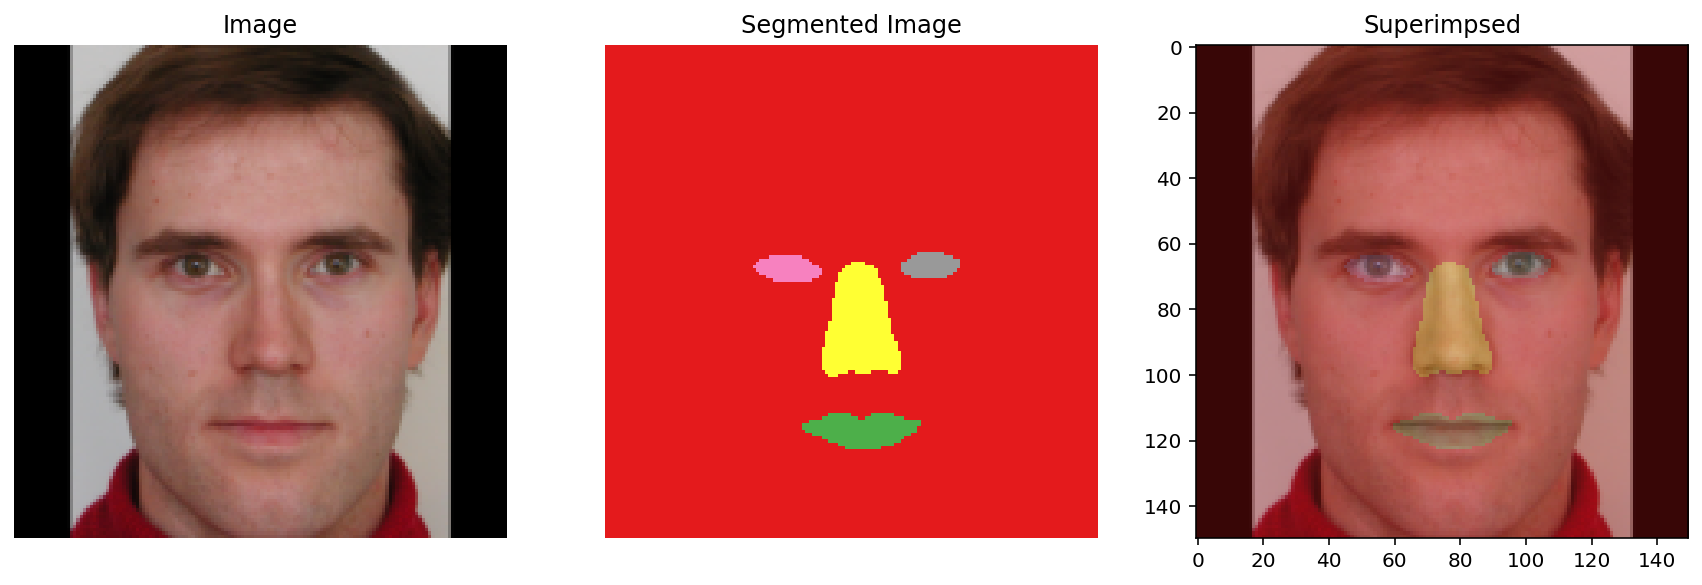

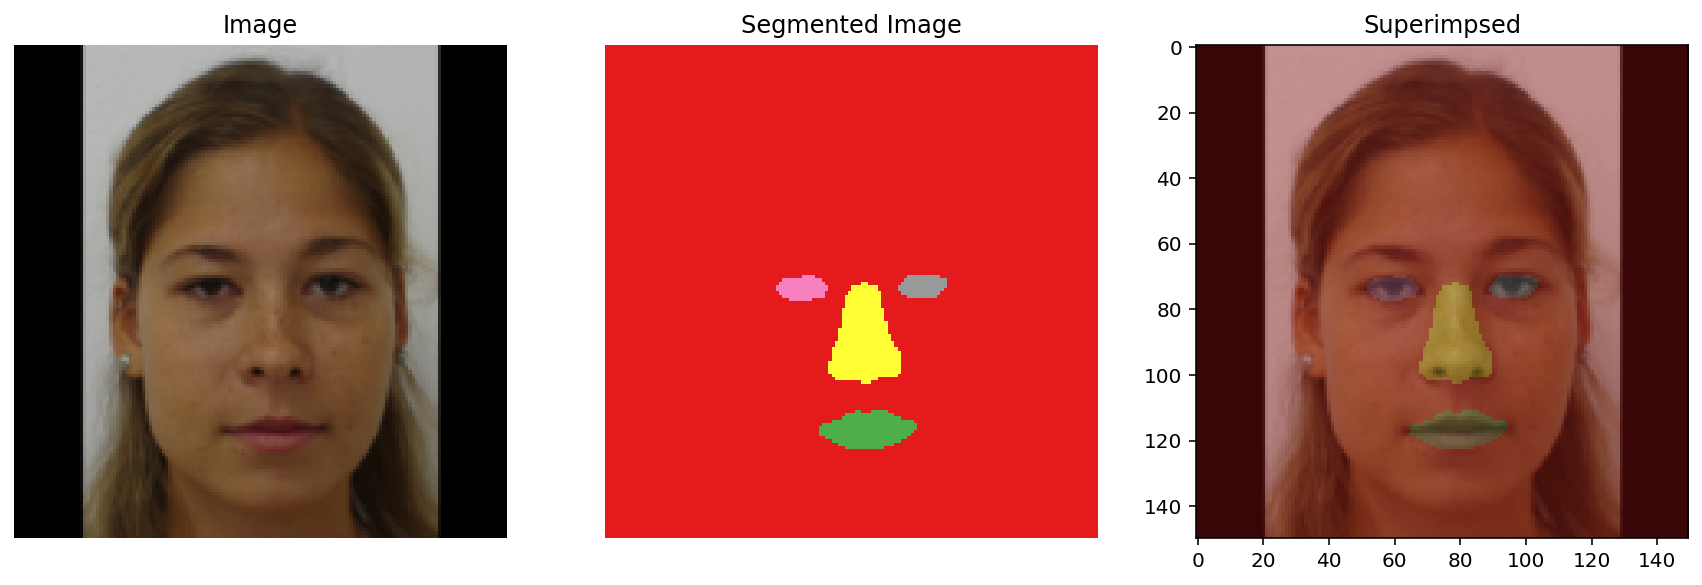

In [25]:
# Inspect some of the images
view_data(X_train, Y_train, 49)
view_data(X_train, Y_train, 10)

## Modelling

### Model 1 - RF No HOG

In [29]:
# Reload modules
reload_modules()

feature_params = {'color': 'gray' , 'loc': True}

# Create preditor features
X_train_f = ftp.create_features(X_train, feature_params)
X_test_f = ftp.create_features(X_test, feature_params)

In [30]:
rfc1 = RandomForestClassifier(n_estimators=30, verbose=0, n_jobs=-1)
rfc1.fit(X_train_f, Y_train.ravel());

In [31]:
score_seg_model(rfc1, X_test_f, Y_test.ravel())

Accuracy Score 0.9727444444444444
              precision    recall  f1-score   support

          nc       0.98      0.99      0.99    517722
       mouth       0.62      0.56      0.59      6234
        nose       0.73      0.72      0.73     10331
    left eye       0.63      0.51      0.56      2806
   right eye       0.66      0.50      0.56      2907

    accuracy                           0.97    540000
   macro avg       0.72      0.66      0.69    540000
weighted avg       0.97      0.97      0.97    540000



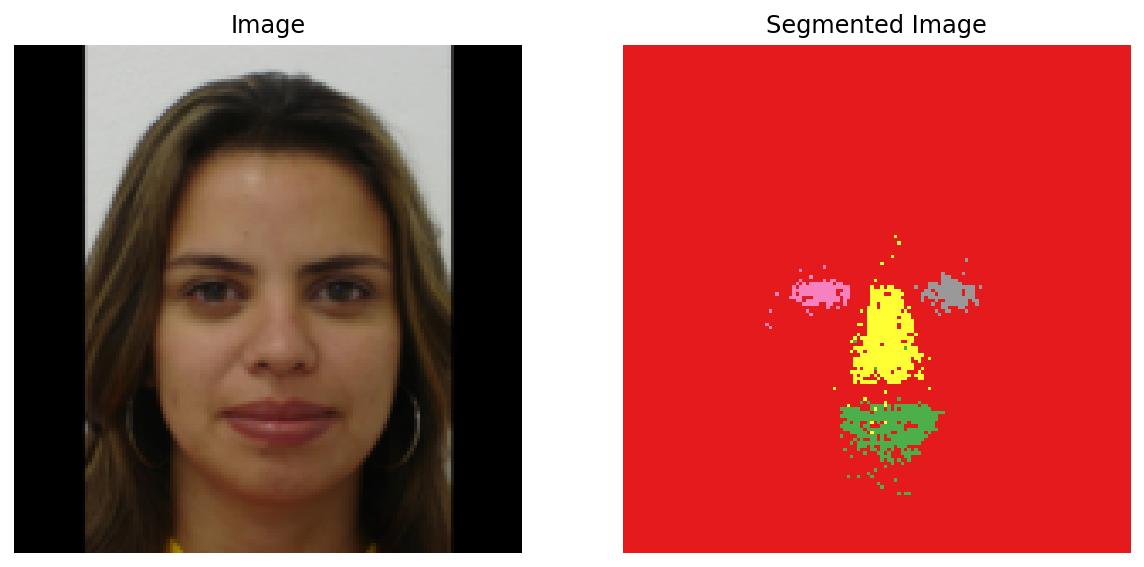

In [32]:
view_prediction(rfc1, X_test[10], feature_params)

### Model 2 - RF with HOG

In [33]:
# Reload moducles
reload_modules()

feature_params = {'color': 'color' , 'loc': True, 'hog': (15,15)}

# Create preditor features
X_train_f = ftp.create_features(X_train,
                                feature_params)
X_test_f = ftp.create_features(X_test,
                               feature_params)

In [34]:
rfc2 = RandomForestClassifier(n_estimators=30, verbose=0, n_jobs=-1)
rfc2.fit(X_train_f, Y_train.ravel());

In [35]:
score_seg_model(rfc2,X_test_f, Y_test.ravel())

Accuracy Score 0.9778425925925925
              precision    recall  f1-score   support

          nc       0.98      0.99      0.99    517722
       mouth       0.80      0.55      0.65      6234
        nose       0.82      0.69      0.75     10331
    left eye       0.79      0.52      0.63      2806
   right eye       0.78      0.50      0.61      2907

    accuracy                           0.98    540000
   macro avg       0.83      0.65      0.73    540000
weighted avg       0.98      0.98      0.98    540000



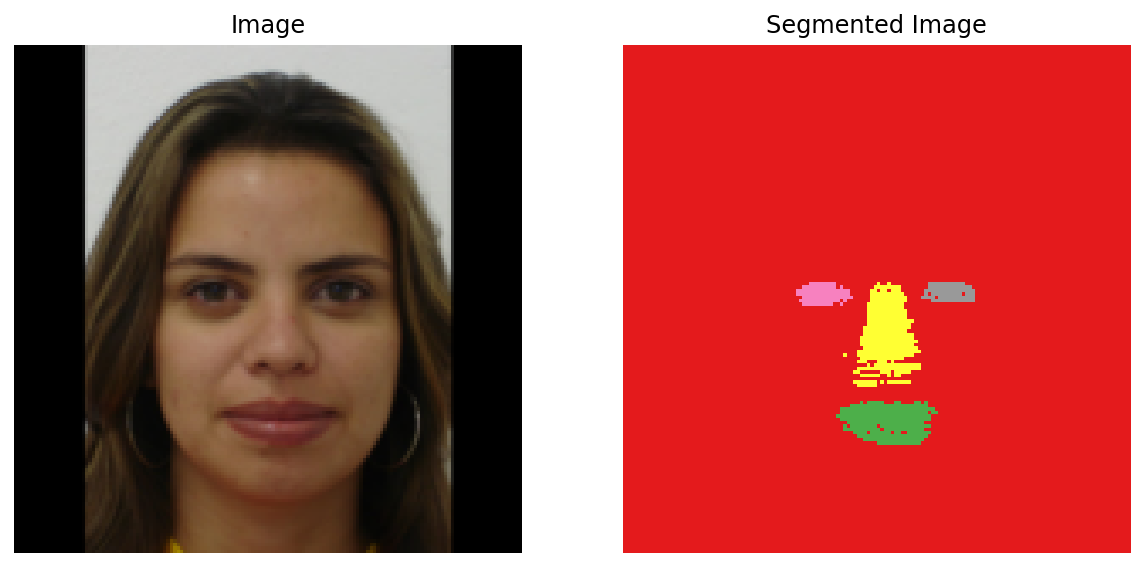

In [36]:
view_prediction(rfc2, X_test[10], feature_params)

### Model 3  - Xgboost with HOG

In [26]:
import xgboost as xgb
feature_params = {'color': 'color' , 'loc': True, 'hog': (15,15)}

# Create preditor features
X_train_f = ftp.create_features(X_train,
                                feature_params)
X_test_f = ftp.create_features(X_test,
                               feature_params)

In [28]:
# Xgboost
xg_clas = xgb.XGBClassifier(verbosity=2)


xg_clas.fit(X_train_f, Y_train.ravel());

[15:45:22] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:45:23] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:45:23] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:45:24] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:45:25] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:45:27] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning en

[15:46:13] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:46:14] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:46:15] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:46:17] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:46:18] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:46:19] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning en

[15:47:07] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:47:10] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:47:11] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:47:11] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:47:12] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:47:13] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning en

[15:48:06] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:48:06] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:48:07] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:48:08] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:48:11] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:48:12] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning en

[15:49:01] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:49:02] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:49:04] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:49:05] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:49:06] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:49:07] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning en

[15:50:04] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:50:05] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:50:05] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:50:06] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:50:07] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:50:10] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning en

[15:51:01] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:51:02] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:51:02] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:51:05] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:51:06] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:51:07] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning en

[15:51:52] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:51:55] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:51:55] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:51:56] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:51:57] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:51:59] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning en

[15:52:55] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:52:56] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:52:56] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:52:57] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:53:00] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[15:53:01] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end

KeyboardInterrupt: 

[15:53:42] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[15:53:45] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:53:46] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:53:47] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:53:48] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:53:48] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end

KeyboardInterrupt: 

KeyboardInterrupt: 

[15:53:54] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:53:58] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[15:53:59] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:54:00] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:54:01] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:54:01] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end

[15:54:49] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:54:49] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:54:50] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:54:51] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[15:54:53] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[15:54:54] INFO: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/tree/updater_prune.cc:74: tree pruning end,

In [ ]:
score_seg_model(xg_clas, X_test_f, Y_test.ravel())

In [ ]:
view_prediction(xg_clas, X_test[17], feature_params, overlap=0.5, ground_truth=Y_test[17])

In [ ]:
reload_modules()
view_prediction(xg_clas, ip.resize_image(real[1], (150,150), preserve_range=False, convert_to_ubyte=True), feature_params)

## Function tests / examples


### Segmenting the labels

In [ ]:
# Working out what the top labels are
make_flat = ip.MakeFlat(seg_v2_labels[4].shape)
flat_image = make_flat.transform(seg_v2_labels[4])

pixel_values = [
    f'{pixel[0]}-{pixel[1]}-{pixel[2]}' for pixel in flat_image[:, :3]
]
pixel_values = pd.Series(pixel_values)
pixel_values.value_counts()[:7]

In [ ]:
masked_img = lbp.mask_image(seg_v2_labels[19],
                            criteria='0-255-0',
                            label_dict=label_dict,
                            method='color',
                            return_type='white')
plt.imshow(masked_img)
plt.show()

# Take a look at the image
plt.imshow(seg_v2_labels[19])
plt.show()

In [ ]:
reload_modules()
img_shape = (600,600)
img = ip.convert_images_to_array(seg_v2_v3_labels[50], img_shape, method='zero_pad')
plt.imshow(img)

In [ ]:
seg_img1 = lbp.segment_labeled_image(img, n_clusters = 7, label_dict=label_dict)

In [ ]:
plt.imshow(seg_img1)

In [ ]:
np.unique(seg_img1)

In [ ]:
img= lbp.mask_image(Y[50], 'mouth', label_dict,method='color_label', return_type ='white')
plt.imshow(img)

In [ ]:
plt.imshow(Y[50])

### Downsizing

In [ ]:
def downsize_array(array, factor):
    
    if len(array.shape) <= 3:
        is_gray = True
    else:
        is_gray = False
        
    new_width = int(array.shape[1]*factor)
    if is_gray:
        new_shape = (array.shape[0], new_width, new_width)
    else:
        new_shape = (array.shape[0], new_width, new_width, 3)
    print(new_shape)
        
    downsized_array = np.empty(shape = new_shape)

    for i, img in enumerate(array):
        downsized_array[i] = skimage.transform.resize(img, output_shape = new_shape[1:], order=0, preserve_range=True)
    return downsized_array

In [ ]:
# Test downsizing on an input image
d_img = downsize_array(v2_test_gray, 1/3)
print('shape', v2_test_gray.shape)
plt.imshow(d_img[0], cmap = 'gray')

In [ ]:
# Test downsizing on a segmented image
d_img_seg= downsize_array(v2_test_seg, 1/3)
print('shape', d_img_seg.shape)
plt.imshow(d_img_seg[0])

In [ ]:
np.unique(d_img_seg[0])